##### L’exercice proposé ci-dessous est basé sur un problème de recalage de modèle à partir de mesures de rigidités transversales pour des enveloppes poids lourd. Les données sont mises à disposition dans les fichiers « 315 80 R 22.5.txt, 385 55 R 22.5.txt, 495 45 R 22.5.txt » avec 3 colonnes : 
- Charge (noté $Fz$) en Newton,
- Pression (noté $P$) en Bar,
- Rigidité (noté $Dz$) en N/°. 

Les coefficients à optimiser sont notés $a1, a2, a3, a4$ et $a5$. Le modèle à ajuster est le suivant :

$ \displaystyle Dz = (a1 \times P + a2) \times \sin \left(a3 \times \arctan{\left(\frac{Fz}{a4 \times P + a5}\right)} \right)$

Cet exercice est séparé en dex parties. La première consiste à résoudre le problème d'identification de paramètres en utilisant des outils classiques d'optimisation. La seconde vise à trouver les solutions via une approche d'optimisation bayesienne.

## Identification par Optimisation Classique

### Chargement des Données

Veuillez tout d'abord charger les mesures de rigidités de dérive contenues dans le fichier " 315 80 R 22.5.txt".

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg as LA
from scipy.optimize import leastsq as LB
import matplotlib.pyplot as plt

#%matplotlib notebook
%matplotlib inline

chemin = "315 80 R 22.5.txt"
mat = np.loadtxt(chemin)
z = mat[:,0]   # N
p  = mat[:,1]   # Bar
dz = mat[:,2]   # N/°

Ces mesures correspondents à des valeurs de rigidités de dérive pour trois niveaux de pression 7, 8.5 et 9.5 bars. Chaque palier de pression comporte 7 points de mesure.
Afficher les mesures $Dz(Fz)$ pour chaque palier de pression

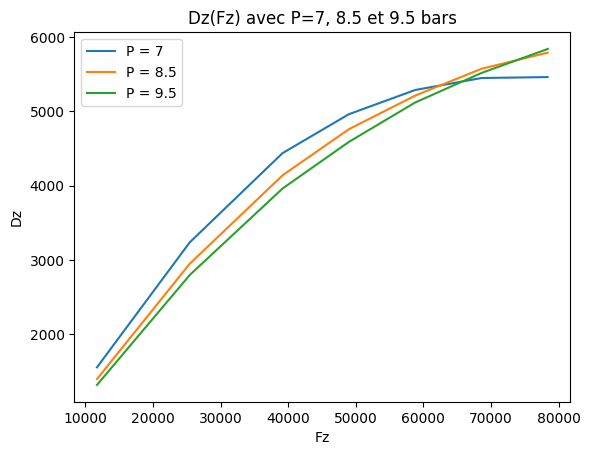

In [2]:
# Affichage des Mesures 

z_7 = z[:7]
z_8_5 = z[7:14]
z_9_5 = z[14:]

p_7 = p[:7]
p_8_5 = p[7:14]
p_9_5 = p[14:]

dz_7 = dz[:7]
dz_8_5 = dz[7:14]
dz_9_5 = dz[14:]

plt.plot(z_7, dz_7, label="P = 7")
plt.plot(z_8_5, dz_8_5, label="P = 8.5")
plt.plot(z_9_5, dz_9_5, label="P = 9.5")
plt.xlabel('Fz')
plt.ylabel('Dz')
plt.legend()
plt.title("Dz(Fz) avec P=7, 8.5 et 9.5 bars")
plt.show()

### Estimation des Valeurs Initiales

L’exercice est un problème d’optimisation continue, non linéaire et sans contrainte. Il est donc nécessaire d'initialiser les paramètres afin de pouvoir lancer un algorithme d'optimisation type recherche linéaire ou région de confiance.

Comment, à votre avis, peut-on essayer d’estimer les coefficients du modèle à partir des mesures ? Pour vous aider, n’oubliez pas que la fonction sinus est bornée. De plus, cadeau, je vous conseille d’approcher a3 par la valeur 2. Il vous reste seulement 4 petits coef à trouver…

Second conseil, le modèle peut également s’écrire sous la forme suivante, idéale quand on connaît déjà $a1, a2$ et $a3$, avec quelques restrictions cependant sur le domaine de définition des fonctions $1/x$, $\arctan$ et $\arcsin$:

$ \displaystyle a4 \times P + a5 = \frac{Fz}{\tan \left(\frac{1}{3} \times \arcsin\left(\frac{Dz}{a1 \times P + a2} \right) \right)}$

In [ ]:
# Estimation initiale de a1 et a2


# Estimation initiale de a4 et a5    



Voici ce que j'ai essayé de faire pour estimer les paramètres :

Pour a1 et a2 :
![Estimation de a1 et a2](../Estimation_a1_a2.png)

<img src="URL_de_l_image" alt="Texte alternatif" width="300" height="200">


Pour a4 et a5 :
![Estimation de a4 et a5](../Estimation_a4_a5.png)

In [3]:
# Estimation de a1

a1_785_1 = (max(dz_7) - max(dz_8_5)) / (7 - 8.5)
a1_785_2 = (max(dz_7) + min(dz_8_5)) / (7 - 8.5)
a1_785_3 = (min(dz_7) + max(dz_8_5)) / (8.5 - 7)
a1_785_4 = (min(dz_7) - min(dz_8_5)) / (8.5 - 7)

a1_795_1 = (max(dz_7) - max(dz_9_5)) / (7 - 9.5)
a1_795_2 = (max(dz_7) + min(dz_9_5)) / (7 - 9.5)
a1_795_3 = (min(dz_7) + max(dz_9_5)) / (9.5 - 7)
a1_795_4 = (min(dz_7) - min(dz_9_5)) / (9.5 - 7)

print(a1_785_1)
print(a1_785_2)
print(a1_785_3)
print(a1_785_4)
print(a1_795_1)
print(a1_795_2)
print(a1_795_3)
print(a1_795_4)
print()

a1 = np.sum(a1_785_1 + a1_785_2 + a1_785_3 + a1_785_4 + a1_795_1 + a1_795_2 + a1_795_3 + a1_795_4) / 8
print(a1)

218.60666666666657
-4573.3
4897.546666666667
105.64000000000003
151.4239999999998
-2712.6
2958.788
94.76400000000004

142.6086666666667


In [4]:
# Estimation de a2

a2_785_1 = max(dz_7) - a1*7
a2_785_2 = -min(dz_7) - a1*7
a2_785_3 = max(dz_8_5) - a1*8.5
a2_785_4 = -min(dz_8_5) - a1*8.5

a2_795_1 = max(dz_7) - a1*7
a2_795_2 = -min(dz_7) - a1*7
a2_795_3 = max(dz_9_5) - a1*9.5
a2_795_4 = -min(dz_9_5) - a1*9.5

print(a2_785_1)
print(a2_785_2)
print(a2_785_3)
print(a2_785_4)
print(a2_795_1)
print(a2_795_2)
print(a2_795_3)
print(a2_795_4)
print()

a2 = np.sum(a2_785_1 + a2_785_2 + a2_785_3 + a2_785_4 + a2_795_1 + a2_795_2 + a2_795_3 + a2_795_4) / 8
print(a2)

4462.509333333333
-2555.900666666667
4576.506333333334
-2611.353666666667
4462.509333333333
-2555.900666666667
4484.547666666666
-2675.5123333333336

948.4256666666668


In [5]:
# Estimation de a3

a3 = 2

In [6]:
# Estimation de a4

a4_785 = ((z_7[0] / np.arctan(1/3 * np.arcsin(dz_7[0] / (a1 * 7 + a2)))) - (z_8_5[0] / np.arctan(1/3 * np.arcsin(dz_8_5[0] / (a1 * 8.5 + a2))))) / (7 - 8.5)
a4_795 = ((z_7[0] / np.arctan(1/3 * np.arcsin(dz_7[0] / (a1 * 7 + a2)))) - (z_9_5[0] / np.arctan(1/3 * np.arcsin(dz_9_5[0] / (a1 * 9.5 + a2))))) / (7 - 9.5)

print(a4_785)
print(a4_795)
print()

a4 = np.sum(a4_785 + a4_795) / 2
print(a4)

7815.213332140901
7716.963881298635

7766.088606719768


In [7]:
# Estimation de a5

a5_785_1 = (z_7[0] / np.arctan(1/3 * np.arcsin(dz_7[0] / (a1 * 7 + a2)))) - a4 * 7
a5_785_2 = (z_8_5[0] / np.arctan(1/3 * np.arcsin(dz_8_5[0] / (a1 * 8.5 + a2)))) - a4 * 8.5
a5_795_1 = (z_7[0] / np.arctan(1/3 * np.arcsin(dz_7[0] / (a1 * 7 + a2)))) - a4 * 7
a5_795_2 = (z_9_5[0] / np.arctan(1/3 * np.arcsin(dz_9_5[0] / (a1 * 9.5 + a2)))) - a4 * 9.5

print(a5_785_1)
print(a5_785_2)
print(a5_795_1)
print(a5_795_2)
print()

a5 = np.sum(a5_785_1 + a5_785_2 + a5_795_1 + a5_795_2) / 4
print(a5)

-15224.18751490597
-15150.500426774277
-15224.18751490597
-15346.999328458813

-15236.468696261258


Superposer les courbes de mesures et de prédictions obtenues avec l'initialisation trouvée. Que constatez-vous?

In [10]:
# Fonction permettant de simuler le modèle
# Entrées: paramètres du modèle
# Return: la valeur de Dz 

#def simulate_model(a1, a2, a3, a4, a5, P, Fz):
def simulate_model(P, Fz):
    return (a1 * P + a2) * (np.sin(a3 * np.arctan(Fz / (a4 * P + a5))))

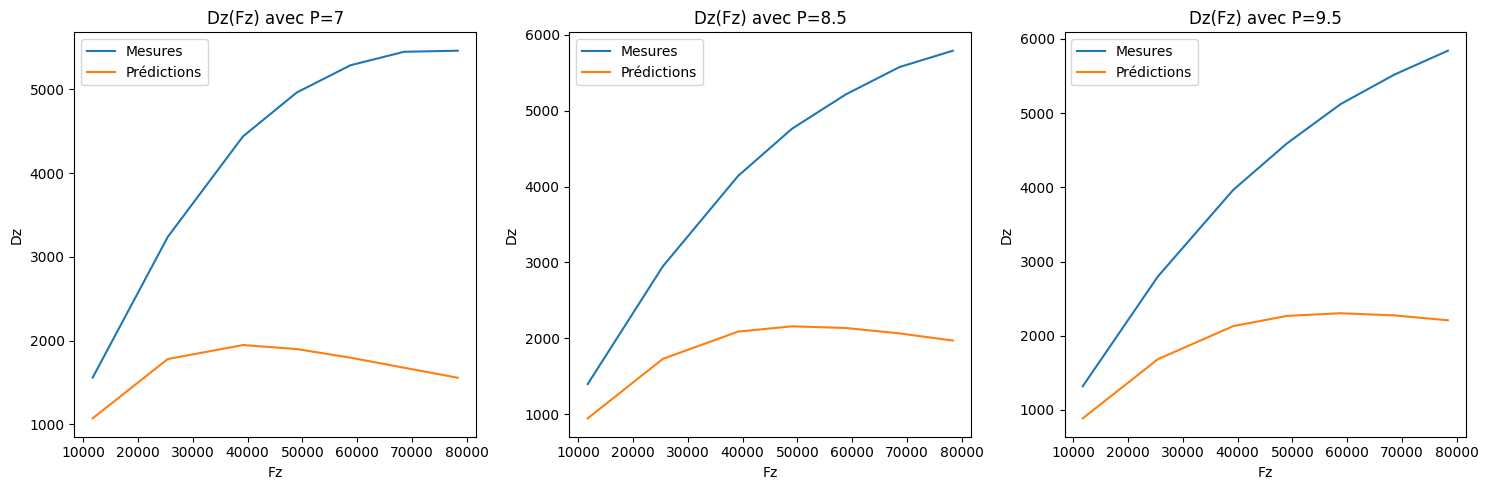

In [11]:
# Affichage de la superposition mesures/prédictions

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 ligne avec 3 plots

pred_7 = [simulate_model(7, z_7[i]) for i in range(len(z_7))]
axes[0].plot(z_7, dz_7, label="Mesures")
axes[0].plot(z_7, pred_7, label="Prédictions")
axes[0].set_xlabel('Fz')
axes[0].set_ylabel('Dz')
axes[0].legend()
axes[0].set_title("Dz(Fz) avec P=7")

pred_8_5 = [simulate_model(8.5, z_8_5[i]) for i in range(len(z_8_5))]
axes[1].plot(z_8_5, dz_8_5, label="Mesures")
axes[1].plot(z_8_5, pred_8_5, label="Prédictions")
axes[1].set_xlabel('Fz')
axes[1].set_ylabel('Dz')
axes[1].legend()
axes[1].set_title("Dz(Fz) avec P=8.5")

pred_9_5 = [simulate_model(9.5, z_9_5[i]) for i in range(len(z_9_5))]
axes[2].plot(z_9_5, dz_9_5, label="Mesures")
axes[2].plot(z_9_5, pred_9_5, label="Prédictions")
axes[2].set_xlabel('Fz')
axes[2].set_ylabel('Dz')
axes[2].legend()
axes[2].set_title("Dz(Fz) avec P=9.5")

plt.tight_layout()
plt.show()

### Fine Tuning des valeurs

Dans le but d'affiner les valeurs obtenues à l'issue de la phase d'initialisation, il est nécessaire de faire appel à un algorithme d'optimisation non linéaire.

En l'occurence, il s'agit d'un problème de curve fitting. 

Quel critère est-il pertinent de considérer? 

Quel type d'algorithme peut-on mettre en oeuvre? 

Implémenter l'optimisation des valeurs des coefficients.

In [ ]:
# Fonction permettant de calculer la fonction coût
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser 



In [ ]:
# Optimisation des paramètres



Superposer les courbes de mesures et de prédictions obtenues avec les valeurs finales trouvées. A-t-on améliorer la qualité de prédiction du modèle par rapport à la phase d'initialisation? Comment peut-on le quantifier?

In [ ]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres


## Identification par Optimisation Bayesienne

Comme précisé plus haut, cette partie vise à résoudre le problème d'identification via une approche bayesienne. Pour ce faire, nous allons nous appuyer sur le package python scikit-optimize (https://scikit-optimize.github.io/stable/).

In [ ]:
from skopt import gp_minimize
from skopt.plots import plot_gaussian_process, plot_convergence

### Premier Essai

Nous travaillons toujours avec la même fonction objectif utilisée dans la première partie du TP. On va considérer de plus les bornes suivantes:
- $200 \leq a1 \leq 300$
- $3000 \leq a2 \leq 4500$
- $1 \leq a3 \leq 3$
- $1e4 \leq a4 \leq 2e4$
- $-5e3 \leq a5 \leq -2e3$

La fonction d'acquisition qui sera utilisée dans un premier temps est l'amélioration espérée (Expected Improvement). Nous fixerons le nombre d'appels à la fonction coût originale à 100. Enfin, on utilise un plan de type LHS avec 50 points pour construire le modèle de krigeage avant la permière minimisation de la fonction d'acquisition.

A l'aide de la documentation du package scikit-optimize, implémenter cette première tentative d'optimisation bayesienne et visualiser le graphe de convergence. A-t-on le même niveau de convergence qu'observé dans la première section du TP? Comment pourrait-on améliorer la convergence?

In [ ]:
# Fonction permettant de calculer la fonction coût au format attendu par scikit-optimize
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser 



In [ ]:
# Définition des bornes


In [ ]:
# Estimation des paramètres par optimisation bayesienne



In [ ]:
# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize



### Amélioration de la configuration de l'algorithme

Essayer différents nombres de points d'évaluation et les fonctions d'acquisition PI et LCB pour tenter d'améliorer le paramétrage de l'algorithme. A partir de l'analyse des graphiques de convergence et de fonctions d'acquisition, quelle est la configuration la plus efficiente?

In [ ]:
# Tests et évaluation avec différentes options du solver



